In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import wntr
import numpy as np
import csv
import pickle
import seaborn as sns

from matplotlib.pyplot import figure
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Get the L_TOWN network:

inp_file = 'C:/Users/GODWIN-PC/Documents/DAMI Lab sessions/BattLeDIM/Dataset Generator/L-TOWN.inp'

wn = wntr.network.WaterNetworkModel(inp_file)

In [3]:


# Bigger network chosen for  thesis picture
# nodes = ['n186','n180','n178','n174', 'n173','n189','n195', 'n197', 'n194','n193']
# pipes = ['p138','p612','p140','p625','p626','p613', 'p85','p94','p628','p143','p630','p629','p616','p141',
#          'p605','p93','p134','p132','p601','p131','p203','p595','p136','p139']

# Second large dataset:
#nodes = ['n170', 'n167', 'n163', 'n161','n168','n171', 'n173','n174']
#pipes = ['p203','p131','p134','p132','p88','p128', 'p578', 'p601', 'p596','p580','p129','p201','p126','p572','p559','p546']

#network on the top
nodes =  ['n218', 'n219', 'n220', 'n221', 'n222']
pipes = ['p683', 'p681', 'p682', 'p690', 'p208', 'p687', 'p686', 'p57']

# Daniel Network
#nodes = ['n321', 'n312', 'n317', 'n313']
#pipes = ['p56', 'p187', 'p811', 'p871', 'p872', 'p885', 'p190', 'p870', 'p869','p219']

pipe_diameter = {pipe: wn.get_link(pipe).diameter for pipe in pipes}

# One hour time step for tests.
#DEFAULT_TIMESTEP =  1 * 60 * 60

# For every 5 minutes
DEFAULT_TIMESTEP =  5 * 60


print("NODES:",nodes)
print("PIPES:",pipes)

NODES: ['n218', 'n219', 'n220', 'n221', 'n222']
PIPES: ['p683', 'p681', 'p682', 'p690', 'p208', 'p687', 'p686', 'p57']


In [4]:
def createNetwork(duration, timestep):
    wn = wntr.network.WaterNetworkModel(inp_file) 
    wn.options.hydraulic.demand_model = 'PDD' 
    wn.options.time.duration = duration 
    wn.options.time.hydraulic_timestep = timestep 
    wn.options.time.report_timestep = timestep 
    return wn


def getLeakArea(pipe, percent): 
    d = pipe_diameter[pipe]
    d *= percent
    area = 3.14159 * (d / 2) ** 2 
    return area


def addLeak(wn, pipe, leak_area, leak_start, leak_duration): 
    node_leak = f'{pipe}_leaknode'
    wn = wntr.morph.split_pipe(wn, pipe, f'{pipe}_X', node_leak) 
    node_leak_ref = wn.get_node(node_leak) 
    node_leak_ref.add_leak(wn, discharge_coeff=0.75, area=leak_area,
        start_time=leak_start, end_time=(leak_start+leak_duration))
    return wn, node_leak


def leakResult(wn, pipe, leak_area, leak_start, leak_duration):
    wn, leak_node = addLeak(wn, pipe, leak_area, leak_start, leak_duration) 
    sim = wntr.sim.WNTRSimulator(wn)
    res = sim.run_sim()
    
    # All the pressure values for the sensors
    data = res.node['pressure'].loc[:,nodes]
    
    # Get leakage in l/m
    leak_data = res.node['leak_demand'].loc[:,leak_node].values 
    leak_data = [e * 3600 for e in leak_data]
    
    leak_or_no_leak = ['leak' if e > 0 else 'no_leak' for e in leak_data] 
    
    pipe_as_str = 'pipe_id: ' + str(pipe)
    pipe_or_no_leak = [pipe_as_str if e > 0 else 'no_leak' for e in leak_data] 
    
    data['leak_occurance'] = leak_or_no_leak
    data['pipe_leak_id'] = pipe_or_no_leak 
    
    # Maybe use for some regression method
    data['leak_amount'] = leak_data 
    return data

In [5]:
# Generate Training data:
def generateTrainData():
    # If we want to use TOWN_Real.inp we dont want
    # to load the network every time for each reset
    # so we use pickle
    wn = createNetwork(2 * 24 * 60 * 60, DEFAULT_TIMESTEP) 
    with open('temp_network.pickle', 'wb') as f:
        pickle.dump(wn, f)
    
    leak_start = 12 * 60 * 60 
    leak_duration = 24 * 60 * 60 
    all_results = []
    
    for pipe in pipes:
        print(pipe)
        
        # Use only one leak size for now.. 
        for leak_fraction in [0.15]:
            with open('temp_network.pickle', 'rb') as f:
                wn = pickle.load(f)
            leak_area = getLeakArea(pipe, leak_fraction)
            all_results.append( leakResult(wn, pipe, leak_area, leak_start,leak_duration) )
    
    # Make on big Dataframe
    big_frame = pd.concat(all_results, axis=0) 
    # Store the data in a csv-file
    with open('train_data_small.csv', 'w') as f:
            w = csv.writer(f)
            w.writerow(big_frame.columns)
            w.writerows(big_frame.values)


In [6]:
generateTrainData()

p683
p681
p682
p690
p208
p687
p686
p57


In [7]:
# Use all sensors
data = pd.read_csv('train_data_small.csv')

#data.drop_duplicates(inplace=True)
data.head()

,n218,n219,n220,n221,n222,leak_occurance,pipe_leak_id,leak_amount
0,44.524665,45.672155,43.410023,45.937154,46.100140,no_leak,no_leak,0.0
1,44.549740,45.697296,43.434387,45.961637,46.124665,no_leak,no_leak,0.0
2,44.574699,45.722321,43.458635,45.986003,46.149073,no_leak,no_leak,0.0
3,44.599029,45.746715,43.482270,46.009753,46.172865,no_leak,no_leak,0.0
4,44.622479,45.770226,43.505047,46.032640,46.195793,no_leak,no_leak,0.0


In [8]:
data.describe()

,n218,n219,n220,n221,n222,leak_amount
count,4616.000000,4616.000000,4616.000000,4616.000000,4616.000000,4616.000000
mean,44.232634,45.380858,43.114275,45.636350,45.799200,19.598869
std,0.596952,0.593824,0.579310,0.578765,0.579333,23.172005
min,42.764098,43.933768,41.721993,44.254507,44.416884,0.000000
25%,43.884276,45.029414,42.764407,45.279067,45.441139,0.000000
50%,44.345015,45.499846,43.233054,45.749309,45.912473,0.000000
75%,44.601180,45.746715,43.470888,45.988847,46.151863,32.141739
max,45.335894,46.484161,44.185442,46.713168,46.877622,56.848770


In [9]:
data.isna().sum()

n218              0
n219              0
n220              0
n221              0
n222              0
leak_occurance    0
pipe_leak_id      0
leak_amount       0
dtype: int64

In [10]:
data_zero_value = (data == 0).sum(axis=0)
print('Ziro values: ', data_zero_value)

Ziro values:  n218                 0
n219                 0
n220                 0
n221                 0
n222                 0
leak_occurance       0
pipe_leak_id         0
leak_amount       2312
dtype: int64


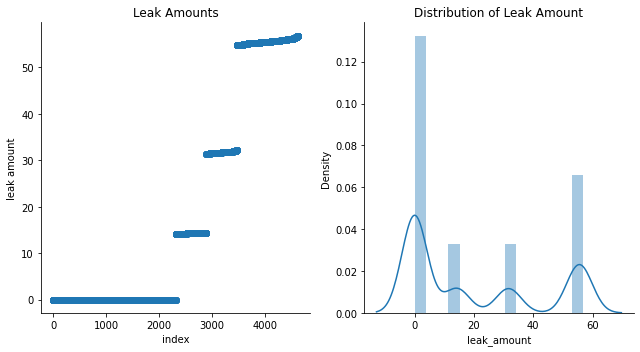

In [11]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(9, 5))

# Scatter plot
axes[0].scatter(range(data.shape[0]), np.sort(data['leak_amount'].values))
axes[0].set_xlabel('index')
axes[0].set_ylabel('leak amount')
axes[0].set_title("Leak Amounts")
sns.despine(ax=axes[0])

# Distribution plot
sns.distplot(data['leak_amount'], ax=axes[1])
axes[1].set_title("Distribution of Leak Amount")
sns.despine(ax=axes[1])

# Adjust spacing between subplots
plt.tight_layout()

# Show the merged plots
plt.show()

In [12]:
# Use all sensors
X = data[nodes]

# 'leak' .. 'no_leak'
y = data['leak_occurance']

print(X)


           n218       n219       n220       n221       n222
0     44.524665  45.672155  43.410023  45.937154  46.100140
1     44.549740  45.697296  43.434387  45.961637  46.124665
2     44.574699  45.722321  43.458635  45.986003  46.149073
3     44.599029  45.746715  43.482270  46.009753  46.172865
4     44.622479  45.770226  43.505047  46.032640  46.195793
...         ...        ...        ...        ...        ...
4611  44.407425  45.554510  43.295973  45.822226  45.984915
4612  44.425719  45.572854  43.313755  45.840097  46.002814
4613  44.444460  45.591647  43.331971  45.858407  46.021154
4614  44.463885  45.611126  43.350850  45.877385  46.040163
4615  44.483988  45.631284  43.370388  45.897024  46.059835

[4616 rows x 5 columns]


In [13]:
print(y.value_counts()) # Shows if the dataset is balanced

no_leak    2312
leak       2304
Name: leak_occurance, dtype: int64


In [14]:
#y= y.map({'leak': 1, 'no_leak': 0}).astype(int)

<AxesSubplot:xlabel='leak_occurance', ylabel='count'>

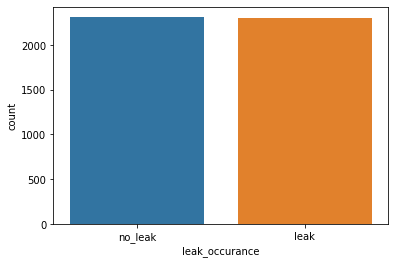

In [15]:

sns.countplot(x = data['leak_occurance'],label="Count")


In [16]:
data['leak_occurance'].value_counts()

no_leak    2312
leak       2304
Name: leak_occurance, dtype: int64

In [17]:
y = y.map({'leak': 1, 'no_leak': 0}).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y)
tuned_params =  {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 

cv_method = KFold(n_splits=4, shuffle=True)
model = SVC()
grid = GridSearchCV(estimator=model, param_grid=tuned_params, cv=cv_method, scoring='accuracy')
grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)
print(grid.best_score_)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.8630825401487139
0.8890814558058926
              precision    recall  f1-score   support

           0       0.84      0.96      0.90       581
           1       0.95      0.82      0.88       573

    accuracy                           0.89      1154
   macro avg       0.90      0.89      0.89      1154
weighted avg       0.90      0.89      0.89      1154



In [18]:
forest_params = [{'max_depth': list(range(10, 15)), 'max_features': list(range(1,14))}]
rfc = RandomForestClassifier()
grid_rf = GridSearchCV(estimator=rfc, param_grid=forest_params,  cv=cv_method, scoring='accuracy')
grid_rf.fit(X_train, y_train)
y_pred = grid_rf.predict(X_test)
print(grid_rf.best_score_)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.9422292381422792
0.9610051993067591
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       581
           1       1.00      0.92      0.96       573

    accuracy                           0.96      1154
   macro avg       0.96      0.96      0.96      1154
weighted avg       0.96      0.96      0.96      1154



In [19]:
dtr = DecisionTreeClassifier()
parameters = {'splitter' : ['best', 'random'],
'criterion' : ['gini', 'entropy'],
'max_features': ['log2', 'sqrt','auto'],
'max_depth': [2, 3, 5, 10, 17],
'min_samples_split': [2, 3, 5, 7, 9],
'min_samples_leaf': [1,5,8,11],
'random_state' : [0,1,2,3,4,5]
}
grid_dt = GridSearchCV(estimator=dtr, param_grid=parameters,  cv=cv_method, scoring='accuracy')
grid_dt.fit(X_train, y_train)
y_pred = grid_dt.predict(X_test)
print(grid_dt.best_score_)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.9485846160007476
0.962738301559792
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       581
           1       0.99      0.93      0.96       573

    accuracy                           0.96      1154
   macro avg       0.96      0.96      0.96      1154
weighted avg       0.96      0.96      0.96      1154



In [20]:
#y = y.map({'leak': 1, 'no_leak': 0}).astype(int)
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }
xgboost = XGBClassifier()
grid_xg = GridSearchCV(estimator=xgboost, param_grid=params,  cv=cv_method, scoring='accuracy')
grid_xg.fit(X_train, y_train)
y_pred = grid_xg.predict(X_test)
print(grid_xg.best_score_)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.9300998544901147
0.9610051993067591
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       581
           1       0.99      0.93      0.96       573

    accuracy                           0.96      1154
   macro avg       0.96      0.96      0.96      1154
weighted avg       0.96      0.96      0.96      1154



In [21]:
# DecisionTree
#y = y.map({'leak': 1, 'no_leak': 0}).astype(int)
def test_tree(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)
    dt = DecisionTreeClassifier() 
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    score = accuracy_score(y_test, y_pred) # accuracy of the model
    precision = precision_score(y_test, y_pred) # precision of the model
    recall = recall_score(y_test, y_pred) # recall of the model
    f1Score = f1_score(y_test, y_pred) # f1_score of the model
    return score, precision,recall, f1Score

In [22]:
score, precision, recall, f1Score = test_tree(X,y)
print("Leak detection DTC accuracy\t: {:.1f}%".format(score*100))
print("Leak detection DTC precision\t: {:.1f}%".format(precision*100))
print("Leak detection DTC recall\t: {:.1f}%".format(recall*100))
print("Leak detection DTC f1_score\t: {:.1f}%".format(f1Score*100))

Leak detection DTC accuracy	: 96.8%
Leak detection DTC precision	: 100.0%
Leak detection DTC recall	: 93.6%
Leak detection DTC f1_score	: 96.7%


In [23]:
# SVC
def test_svc(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=3)
    model = SVC()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred) # accuracy of the model
    precision = precision_score(y_test, y_pred) # precision of the model
    recall = recall_score(y_test, y_pred) # recall of the model
    f1Score = f1_score(y_test, y_pred) # f1_score of the model
    return score, precision, recall, f1Score


In [24]:
score , precision, recall, f1Score= test_svc(X,y)
print("Leak detection SVC accuracy\t: {:.1f}%".format(score*100))
print("Leak detection SVC precision\t: {:.1f}%".format(precision*100))
print("Leak detection SVC recall\t: {:.1f}%".format(recall*100))
print("Leak detection SVC f1_score\t: {:.1f}%".format(f1Score*100))

Leak detection SVC accuracy	: 70.9%
Leak detection SVC precision	: 78.6%
Leak detection SVC recall	: 58.2%
Leak detection SVC f1_score	: 66.9%


In [25]:
# XGBoost
def test_gb(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=3)
    clf1 = XGBClassifier()
    clf1.fit(X_train, y_train)
    y_pred = clf1.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred) # precision of the model
    recall = recall_score(y_test, y_pred) # recall of the model
    f1Score = f1_score(y_test, y_pred) # f1_score of the model
    return score, precision, recall, f1Score

In [26]:
score, precision, recall, f1Score = test_gb(X,y)
print("Leak detection XGBoost accuracy\t: {:.1f}%".format(score*100))
print("Leak detection XGBoost precision\t: {:.1f}%".format(precision*100))
print("Leak detection XGBoost recall\t: {:.1f}%".format(recall*100))
print("Leak detection XGBoost f1_score\t: {:.1f}%".format(f1Score*100))

Leak detection XGBoost accuracy	: 95.1%
Leak detection XGBoost precision	: 100.0%
Leak detection XGBoost recall	: 90.4%
Leak detection XGBoost f1_score	: 94.9%


In [27]:
# Random forest
def test_rf(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=3)
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = accuracy_score(y_test, y_pred) 
    precision = precision_score(y_test, y_pred) # precision of the model
    recall = recall_score(y_test, y_pred) # recall of the model
    f1Score = f1_score(y_test, y_pred) # f1_score of the model
    return score, precision, recall, f1Score

In [28]:
score, precision, recall, f1Score = test_rf(X,y)
print("Leak detection RandomForest Accuracy\t: {:.1f}%".format(score*100))
print("Leak detection RandomForest precision\t: {:.1f}%".format(precision*100))
print("Leak detection RandomForest recall\t: {:.1f}%".format(recall*100))
print("Leak detection RandomForest f1_score\t: {:.1f}%".format(f1Score*100))

Leak detection RandomForest Accuracy	: 96.6%
Leak detection RandomForest precision	: 100.0%
Leak detection RandomForest recall	: 93.4%
Leak detection RandomForest f1_score	: 96.6%


In [29]:

score_DT, precision_DT, recall_DT, f1Score_DT = test_tree(X,y)
print("Leak detection DTC accuracy\t: {:.1f}%".format(score_DT*100))
print("Leak detection DTC precision\t: {:.1f}%".format(precision_DT*100))
print("Leak detection DTC recall\t: {:.1f}%".format(recall_DT*100))
print("Leak detection DTC f1_score\t: {:.1f}%".format(f1Score_DT*100))
print('-------------------------------------------------------------')
score_SVC , precision_SVC, recall_SVC, f1Score_SVC= test_svc(X,y)
print("Leak detection SVC accuracy\t: {:.1f}%".format(score_SVC*100))
print("Leak detection SVC precision\t: {:.1f}%".format(precision_SVC*100))
print("Leak detection SVC recall\t: {:.1f}%".format(recall_SVC*100))
print("Leak detection SVC f1_score\t: {:.1f}%".format(f1Score_SVC*100))
print('-------------------------------------------------------------')
score_XG, precision_XG, recall_XG, f1Score_XG = test_gb(X,y)
print("Leak detection XGBoost accuracy\t: {:.1f}%".format(score_XG*100))
print("Leak detection XGBoost precision\t: {:.1f}%".format(precision_XG*100))
print("Leak detection XGBoost recall\t: {:.1f}%".format(recall_XG*100))
print("Leak detection XGBoost f1_score\t: {:.1f}%".format(f1Score_XG*100))
print('-------------------------------------------------------------')
score_RF, precision_RF, recall_RF, f1Score_RF = test_rf(X,y)
print("Leak detection RandomForest Accuracy\t: {:.1f}%".format(score_RF*100))
print("Leak detection RandomForest precision\t: {:.1f}%".format(precision_RF*100))
print("Leak detection RandomForest recall\t: {:.1f}%".format(recall_RF*100))
print("Leak detection RandomForest f1_score\t: {:.1f}%".format(f1Score_RF*100))

Leak detection DTC accuracy	: 96.1%
Leak detection DTC precision	: 100.0%
Leak detection DTC recall	: 92.3%
Leak detection DTC f1_score	: 96.0%
-------------------------------------------------------------
Leak detection SVC accuracy	: 70.9%
Leak detection SVC precision	: 78.6%
Leak detection SVC recall	: 58.2%
Leak detection SVC f1_score	: 66.9%
-------------------------------------------------------------
Leak detection XGBoost accuracy	: 95.1%
Leak detection XGBoost precision	: 100.0%
Leak detection XGBoost recall	: 90.4%
Leak detection XGBoost f1_score	: 94.9%
-------------------------------------------------------------
Leak detection RandomForest Accuracy	: 96.6%
Leak detection RandomForest precision	: 100.0%
Leak detection RandomForest recall	: 93.4%
Leak detection RandomForest f1_score	: 96.6%
